In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, model_selection

import time
#from matplotlib import pyplot as plt
from matplotlib import pylab as plt
from IPython import display

from Funciones import evaluar, evaluarDerivada

In [3]:
df_train = pd.read_csv(DATOS_DIR + 'optdigits_train.csv')
X_train = np.array(df_train.iloc[:,:-1]).astype(float)
Y_train = np.array(df_train.iloc[:,-1])

df_test = pd.read_csv(DATOS_DIR + 'optdigits_test.csv')
X_test = np.array(df_test.iloc[:,:-1]).astype(float)
Y_test = np.array(df_test.iloc[:,-1])

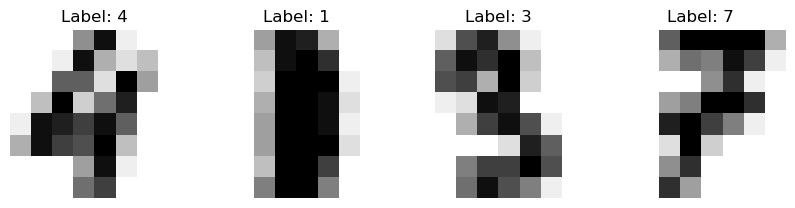

In [4]:
# visualizando algunos dígitos de df_train

# Selecciona 4 filas aleatorias del dataframe
sample_images = df_train.sample(4)

# Extrae las imágenes y las etiquetas (asumiendo que las etiquetas están en la última columna)
images = sample_images.iloc[:, :-1].values
labels = sample_images.iloc[:, -1].values

# Redimensiona las imágenes a 8x8
images = images.reshape((4, 8, 8))

# Crea una figura con 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap=plt.cm.gray_r) #cmap='gray')
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')

plt.show()

In [5]:
entradas = X_train.shape[1]
ocultas = 15

#-- la red tendrá una salida para cada dígito
salidas = 10
print("entradas = %d ; salidas = %d" % (entradas, salidas))

Y_trainB = np.zeros((len(Y_train), salidas))
for o in range(len(Y_train)):
    Y_trainB[o, Y_train[o]]=1
    
Y_testB = np.zeros((len(Y_test), salidas))
for o in range(len(Y_test)):
    Y_testB[o, Y_test[o]]=1

entradas = 64 ; salidas = 10


In [6]:
normalizarEntrada = 1  # 1 si normaliza; 0 si no

if normalizarEntrada:
    # Escala los valores entre 0 y 1
    min_max_scaler = preprocessing.StandardScaler()
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    

In [7]:
W1 = np.random.uniform(-0.5,0.5,[ocultas, entradas])
b1 = np.random.uniform(-0.5,0.5, [ocultas,1])
W2 = np.random.uniform(-0.5,0.5,[salidas, ocultas])
b2 = np.random.uniform(-0.5,0.5, [salidas,1])

In [8]:
FunH = 'sigmoid'
FunO = 'sigmoid'

if (FunO=='tanh'):
    Y_trainB = 2*Y_trainB -1
    Y_testB  = 2*Y_testB - 1

**Cómo obtener la salida para un ejemplo dado**

In [9]:
e = 0  # nro de ejemplo a ingresar a la red

xi = X_train[e:e+1, :]     # ejemplo a ingresar a la red
yi = Y_trainB[e:e+1, :]     # salida esperada para el ejemplo seleccionado

# propagar el ejemplo hacia adelante
netasH = W1 @ xi.T + b1

salidasH = evaluar(FunH, netasH)
netasO = W2 @ salidasH + b2

salidasO = evaluar(FunO, netasO)

print(f"xi: {xi.shape}, yi: {yi.shape}")
print(f"\nnetasH: {netasH.shape}, W1: {W1.shape}, xi.T: {xi.T.shape}, b1: {b1.shape}")
print(f"\nnetasO: {netasO.shape}, W2: {W2.shape}, salidasH: {salidasH.shape}, b2: {b2.shape}")
print(f"\nsalidasO: {salidasO.shape}")

xi: (1, 64), yi: (1, 10)

netasH: (15, 1), W1: (15, 64), xi.T: (64, 1), b1: (15, 1)

netasO: (10, 1), W2: (10, 15), salidasH: (15, 1), b2: (10, 1)

salidasO: (10, 1)


**Calculamos las correcciones de ambas capas**

In [10]:
ErrorSalida = yi.T-salidasO
        
deltaO = ErrorSalida * evaluarDerivada(FunO,salidasO)
deltaH = evaluarDerivada(FunH,salidasH)*(W2.T @ deltaO)

print(f"ErrorSalida: {ErrorSalida.shape}, yi.T: {yi.T.shape}, salidasO: {salidasO.shape}")
print(f"\ndeltaO: {deltaO.shape}, ErrorSalida: {ErrorSalida.shape}, salidasO: {salidasO.shape}")
print(f"\ndeltaH: {deltaH.shape}, salidasH: {salidasH.shape}, W2.T: {W2.T.shape}, deltaO: {deltaO.shape}, (W2.T @ deltaO): {(W2.T @ deltaO).shape}")

ErrorSalida: (10, 1), yi.T: (10, 1), salidasO: (10, 1)

deltaO: (10, 1), ErrorSalida: (10, 1), salidasO: (10, 1)

deltaH: (15, 1), salidasH: (15, 1), W2.T: (15, 10), deltaO: (10, 1), (W2.T @ deltaO): (15, 1)


**Corregimos los pesos**

In [11]:
alfa = 0.1

# corregir todos los pesos      
W1 = W1 + alfa * deltaH @ xi 
b1 = b1 + alfa * deltaH 
W2 = W2 + alfa * deltaO @ salidasH.T 
b2 = b2 + alfa * deltaO 

print(f"W1: {W1.shape}, deltaH: {deltaH.shape}, xi: {xi.shape}, (deltaH @ xi): {(deltaH @ xi).shape}")
print(f"\nb1: {b1.shape}, deltaH: {deltaH.shape}")

print(f"\nW2: {W2.shape}, deltaO: {deltaO.shape}, salidasH.T: {salidasH.T.shape}, (deltaO @ salidasH.T): {(deltaO @ salidasH.T).shape}")
print(f"\nb2: {b2.shape}, deltaO: {deltaO.shape}")

W1: (15, 64), deltaH: (15, 1), xi: (1, 64), (deltaH @ xi): (15, 64)

b1: (15, 1), deltaH: (15, 1)

W2: (10, 15), deltaO: (10, 1), salidasH.T: (1, 15), (deltaO @ salidasH.T): (10, 15)

b2: (10, 1), deltaO: (10, 1)


**ENTRENAMIENTO**

In [12]:
nFilas = X_train.shape[0]

alfa = 0.1
CotaError = 1.0e-4
MAX_EPOCAS = 400
epoca = 0

errorAnt = 0
AVGError = 1

errores = []

print("Inicio ...")
tIni = time.time()

while ( abs(AVGError-errorAnt) > CotaError ) and ( epoca < MAX_EPOCAS ):
    errorAnt = AVGError
    AVGError = 0
    for e in range(nFilas):  #para cada ejemplo

        xi = X_train[e:e+1, :]     # ejemplo a ingresar a la red
        yi = Y_trainB[e:e+1, :]     # salida esperada para el ejemplo seleccionado
        
        # propagar el ejemplo hacia adelante
        netasH = W1 @ xi.T + b1
        salidasH = evaluar(FunH, netasH)
        netasO = W2 @ salidasH + b2
        salidasO = evaluar(FunO, netasO)

        # calcular los errores en ambas capas        
        ErrorSalida = yi.T-salidasO
        
        deltaO = ErrorSalida * evaluarDerivada(FunO,salidasO)
        deltaH = evaluarDerivada(FunH,salidasH)*(W2.T @ deltaO)

        # corregir todos los pesos      
        W1 = W1 + alfa * deltaH @ xi 
        b1 = b1 + alfa * deltaH 
        W2 = W2 + alfa * deltaO @ salidasH.T 
        b2 = b2 + alfa * deltaO 

        AVGError = AVGError + np.mean(ErrorSalida**2)
    
    AVGError = AVGError / nFilas
    errores.append(AVGError)
    
    epoca = epoca + 1

tFin = time.time()
print("duración %.7f seg" % (tFin- tIni))
    

Inicio ...
duración 5.1152699 seg


In [13]:
print(f"nEj: {len(X_train)}, epocas : {len(errores)}, iteraciones: {len(errores)*nFilas}")

nEj: 3823, epocas : 21, iteraciones: 80283


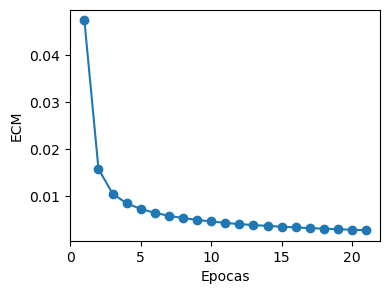

In [14]:
plt.figure(figsize=(4,3))
plt.plot(range(1, len(errores) + 1), errores, marker='o')
plt.xlabel('Epocas')
plt.ylabel('ECM')
plt.show()

In [15]:
# Respuesta de la red para los datos de ENTRENAMIENTO ---
NetasH = W1 @ X_train.T + b1
SalidasH = evaluar(FunH, NetasH)
NetasO = W2 @ SalidasH + b2
SalidasO = evaluar(FunO, NetasO)
np.round(SalidasO[:, :5],3)

array([[0.986, 0.997, 0.001, 0.004, 0.086],
       [0.   , 0.   , 0.   , 0.034, 0.   ],
       [0.001, 0.009, 0.004, 0.   , 0.001],
       [0.003, 0.002, 0.002, 0.   , 0.001],
       [0.02 , 0.017, 0.004, 0.904, 0.008],
       [0.008, 0.005, 0.001, 0.002, 0.066],
       [0.004, 0.004, 0.   , 0.   , 0.905],
       [0.001, 0.001, 0.997, 0.001, 0.   ],
       [0.004, 0.004, 0.   , 0.032, 0.046],
       [0.002, 0.005, 0.001, 0.223, 0.   ]])

In [16]:
Y_pred = np.argmax(SalidasO,axis=0)
print("%% aciertos X_train : %.3f" % metrics.accuracy_score(Y_train,Y_pred))

% aciertos X_train : 0.991


In [17]:
report = metrics.classification_report(Y_train,Y_pred)
print("Confusion matrix Training:\n%s" % report) 

Confusion matrix Training:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       376
           1       0.98      0.99      0.99       389
           2       0.99      1.00      1.00       380
           3       0.99      0.98      0.99       389
           4       0.99      1.00      0.99       387
           5       0.99      0.99      0.99       376
           6       0.99      1.00      1.00       377
           7       0.99      1.00      1.00       387
           8       1.00      0.98      0.99       380
           9       0.98      0.98      0.98       382

    accuracy                           0.99      3823
   macro avg       0.99      0.99      0.99      3823
weighted avg       0.99      0.99      0.99      3823



In [18]:
MM = metrics.confusion_matrix(Y_train,Y_pred)
print("Confusion matrix:\n%s" % MM)

Confusion matrix:
[[374   0   0   0   1   0   1   0   0   0]
 [  0 386   0   0   0   0   0   1   0   2]
 [  1   0 379   0   0   0   0   0   0   0]
 [  0   1   0 383   0   4   0   0   0   1]
 [  0   0   0   0 386   0   1   0   0   0]
 [  0   0   1   0   0 372   0   0   0   3]
 [  0   1   0   0   0   0 376   0   0   0]
 [  0   0   0   1   0   0   0 386   0   0]
 [  1   3   0   0   2   0   0   1 373   0]
 [  1   2   1   1   2   0   0   0   1 374]]


In [19]:
# -- TESTING ---
NetasH = W1 @ X_test.T + b1
SalidasH = evaluar(FunH, NetasH)
NetasO = W2 @ SalidasH + b2
SalidasO = evaluar(FunO, NetasO)

Y_pred = np.argmax(SalidasO,axis=0)
print("%% aciertos X_test : %.3f\n" % metrics.accuracy_score(Y_test,Y_pred))

report = metrics.classification_report(Y_test, Y_pred)
print("Confusion matrix Test:\n%s" % report) 

MM = metrics.confusion_matrix(Y_test, Y_pred)
print("Confusion matrix:\n%s" % MM)

% aciertos X_test : 0.953

Confusion matrix Test:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       178
           1       0.92      0.97      0.94       182
           2       0.96      0.94      0.95       177
           3       0.98      0.92      0.95       183
           4       0.95      0.98      0.96       181
           5       0.92      0.96      0.94       182
           6       0.99      0.98      0.99       181
           7       0.98      0.93      0.95       179
           8       0.92      0.89      0.91       174
           9       0.92      0.96      0.94       180

    accuracy                           0.95      1797
   macro avg       0.95      0.95      0.95      1797
weighted avg       0.95      0.95      0.95      1797

Confusion matrix:
[[175   0   0   0   2   1   0   0   0   0]
 [  0 176   1   0   0   0   1   0   2   2]
 [  0   3 167   2   2   0   0   1   2   0]
 [  0   0   5 169   0   3   0   2   2   2]
 